## Bài thực hành: Phân loại động vật nguy hiểm với SVM

### 1. Import thư viện

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Cấu hình hiển thị
mpl.style.use('seaborn-v0_8')
mpl.rcParams['figure.dpi'] = 300

### 2. Nạp dữ liệu và tiền xử lý

In [9]:
# 1. Nạp dữ liệu
df = pd.read_csv("data.csv")

# 2. Tiền xử lý
# Loại bỏ dòng thiếu nhãn
df = df[df['Dangerous'].notna()]

Cột AnimalName, symptoms1…symptoms5 đều là dạng text → cần mã hóa.
Cột Dangerous là nhãn (Yes/No).

In [10]:
# Encode nhãn
le_target = LabelEncoder()
df['Dangerous'] = le_target.fit_transform(df['Dangerous'])  # Yes → 1, No → 0

# Gộp các cột triệu chứng thành một chuỗi đặc trưng
symptom_cols = ['symptoms1','symptoms2','symptoms3','symptoms4','symptoms5']
df['symptoms'] = df[symptom_cols].fillna('').agg(' '.join, axis=1)

# Encode AnimalName và symptoms
le_animal = LabelEncoder()
le_symptom = LabelEncoder()
df['AnimalName'] = le_animal.fit_transform(df['AnimalName'])
df['symptoms'] = le_symptom.fit_transform(df['symptoms'])

### 3. Chia dữ liệu train/test và chuẩn hóa

In [11]:
# 3. Chia dữ liệu
X = df[['AnimalName','symptoms']]
y = df['Dangerous']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 4. Huấn luyện mô hình SVM cơ bản

In [12]:
clf = svm.SVC(kernel='linear', probability=True, random_state=42)
clf.fit(X_train_scaled, y_train)

print("Train acc:", clf.score(X_train_scaled, y_train))
print("Test acc:", clf.score(X_test_scaled, y_test))

Train acc: 0.9741007194244604
Test acc: 0.9885057471264368


### 5. Thử nhiều kernel và chọn mô hình tốt nhất

In [13]:
kernels = ['linear','poly','rbf','sigmoid']
for k in kernels:
    model = svm.SVC(kernel=k, probability=True, random_state=42)
    model.fit(X_train_scaled, y_train)
    acc = model.score(X_test_scaled, y_test)
    print(f"Kernel={k}, Test acc={acc:.4f}")

Kernel=linear, Test acc=0.9885
Kernel=poly, Test acc=0.9885
Kernel=rbf, Test acc=0.9885
Kernel=sigmoid, Test acc=0.9885


### 6. Tối ưu tham số bằng GridSearchCV

In [14]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear','rbf'],
    'gamma': ['scale','auto']
}

grid = GridSearchCV(svm.SVC(probability=True, random_state=42),
                    param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_scaled, y_train)

print("Best params:", grid.best_params_)
print("Best CV acc:", grid.best_score_)

Best params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best CV acc: 0.9741007194244604


### 7. Đánh giá mô hình tốt nhất

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.99      1.00      0.99       172

    accuracy                           0.99       174
   macro avg       0.49      0.50      0.50       174
weighted avg       0.98      0.99      0.98       174



C:\Users\hienm\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\hienm\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\hienm\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

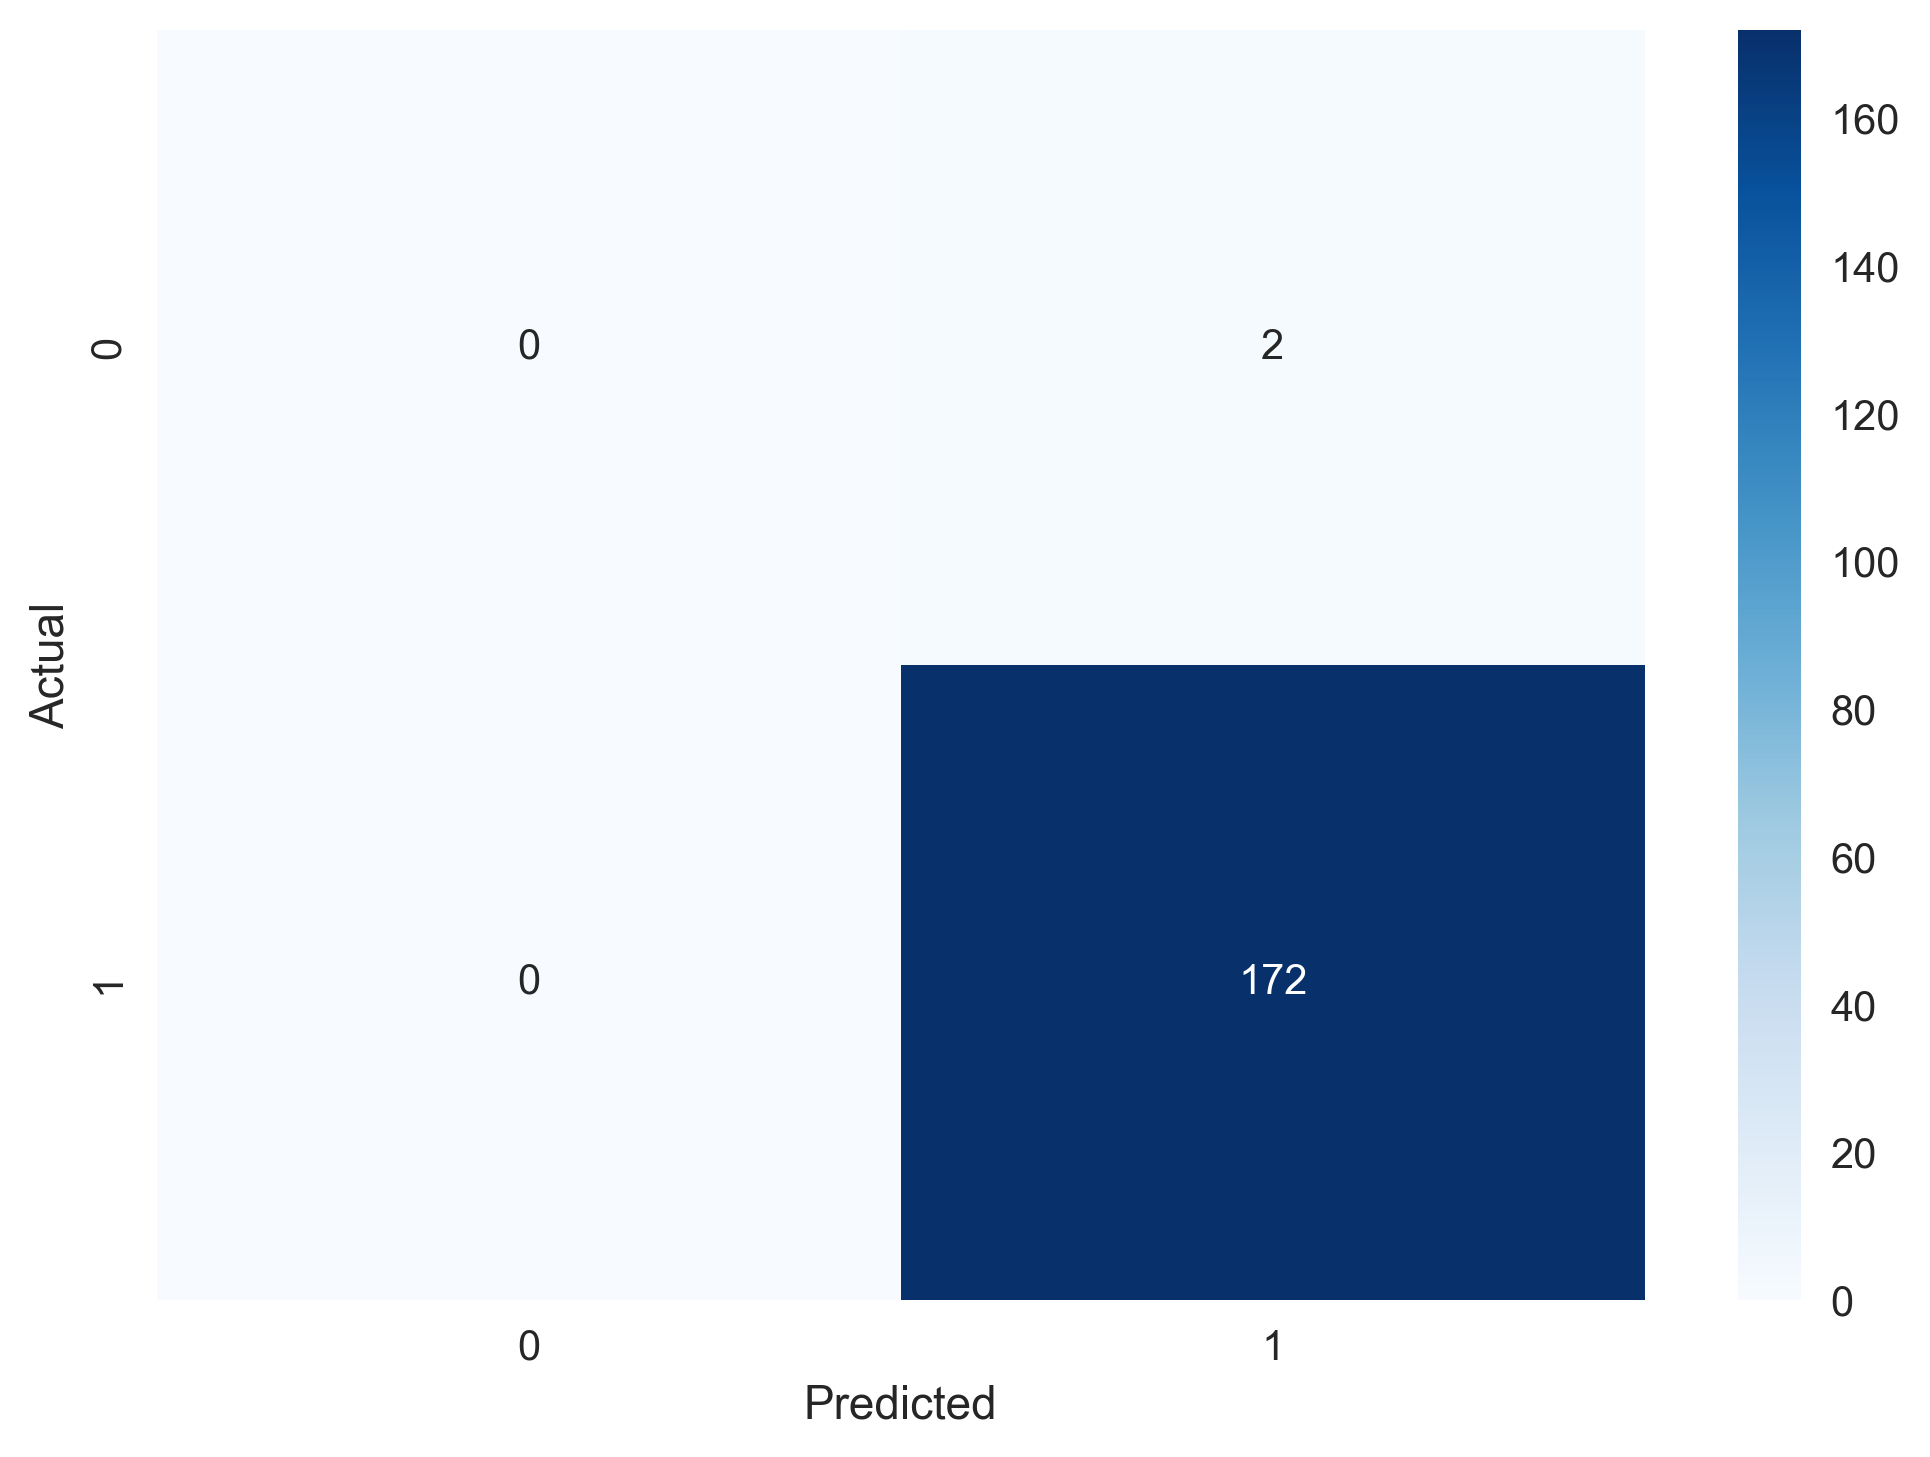

In [15]:
y_pred = grid.best_estimator_.predict(X_test_scaled)

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()